# XGBOOST V3

In [13]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\swali\AppData\Local\Temp\ipykernel_41080\1542413940.py:3: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('data\data_hep - data_hep.csv')


Dataset shape: (70606, 61)
Columns: ['index', 'R2', 'thrustBm', 'thrustOm', 'cosTBTO', 'cosTBz', 'KSFWVariables__boet__bc', 'KSFWVariables__bomm2__bc', 'CleoConeCS__bo1__bc', 'CleoConeCS__bo2__bc']...

Class distribution:
binary_type
0    35765
1    34841
Name: count, dtype: int64
Class proportions:
binary_type
0    0.506543
1    0.493457
Name: proportion, dtype: float64

Feature matrix shape: (70606, 59)
Number of features: 59

Train set size: (56484, 59)
Test set size: (14122, 59)
[0]	train-logloss:0.64209	train-auc:0.91300	train-error:0.15925	test-logloss:0.64265	test-auc:0.90872	test-error:0.16131
[50]	train-logloss:0.28515	train-auc:0.95331	train-error:0.11780	test-logloss:0.31296	test-auc:0.94081	test-error:0.13291
[100]	train-logloss:0.23988	train-auc:0.96782	train-error:0.09604	test-logloss:0.29170	test-auc:0.94762	test-error:0.12392
[150]	train-logloss:0.21297	train-auc:0.97584	train-error:0.08241	test-logloss:0.28433	test-auc:0.94994	test-error:0.12229
[200]	train-logloss:0.1

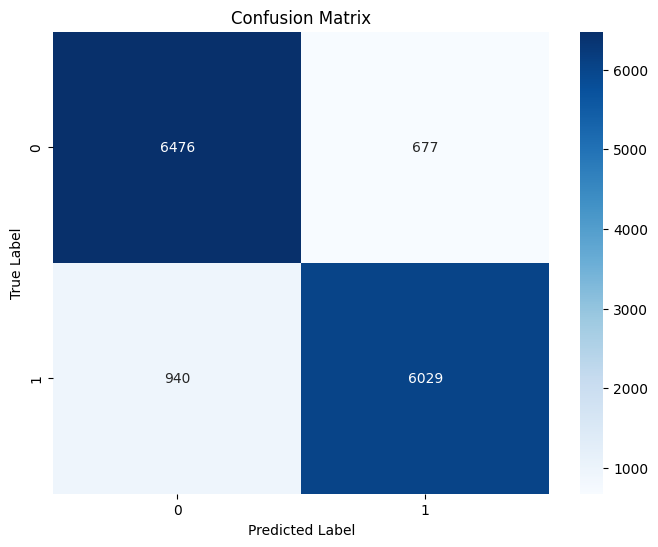


FEATURE IMPORTANCE FOR REDUCTION

Top 20 Most Important Features (by gain):
                              feature  importance
0                                  R2  186.537781
2                            thrustOm   27.851175
7                 CleoConeCS__bo1__bc   17.039829
16         CleoConeCS__bo1__cmROE__bc   14.219336
1                            thrustBm   13.844634
34          KSFWVariables__bohoo0__bc   10.733978
32         KSFWVariables__bohso22__bc    9.413470
45  KSFWVariables__bohso20__cmFS1__bc    9.195106
48   KSFWVariables__bohoo0__cmFS1__bc    9.073476
31         KSFWVariables__bohso20__bc    9.053622
6            KSFWVariables__bomm2__bc    8.455488
4                              cosTBz    8.455178
8                 CleoConeCS__bo2__bc    8.128288
5             KSFWVariables__boet__bc    8.042714
50   KSFWVariables__bohoo2__cmFS1__bc    7.924239
29         KSFWVariables__bohso12__bc    7.840838
3                             cosTBTO    6.745912
54                     

<Figure size 1000x1200 with 0 Axes>

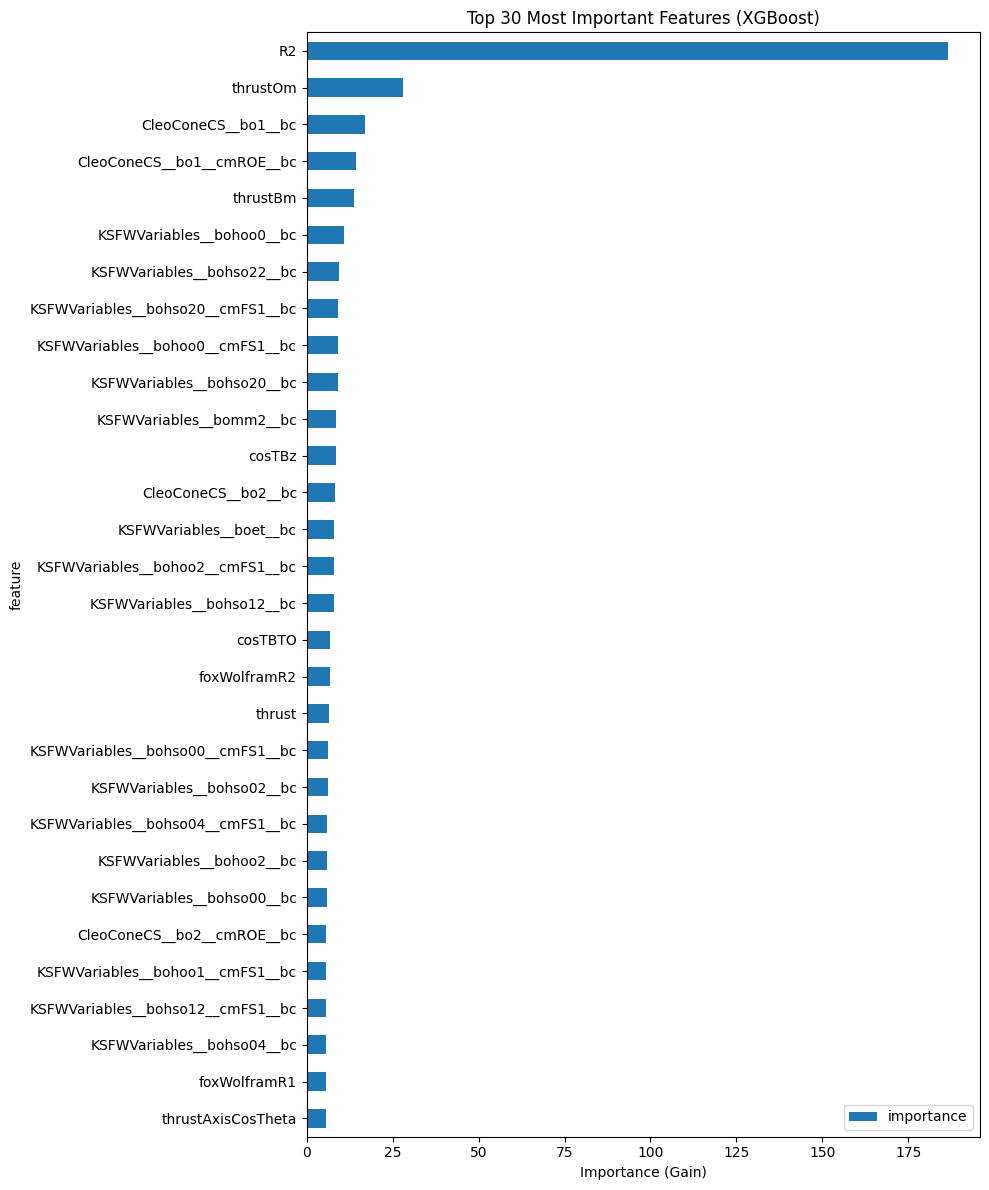


FEATURE REDUCTION SUGGESTIONS

To capture 80% of importance, use top 34 features
Reduction: 59 -> 34 features (57.6% of original)

To capture 90% of importance, use top 46 features
Reduction: 59 -> 46 features (78.0% of original)

To capture 95% of importance, use top 52 features
Reduction: 59 -> 52 features (88.1% of original)

Top 50 features saved. You can retrain using these features:
['R2', 'thrustOm', 'CleoConeCS__bo1__bc', 'CleoConeCS__bo1__cmROE__bc', 'thrustBm', 'KSFWVariables__bohoo0__bc', 'KSFWVariables__bohso22__bc', 'KSFWVariables__bohso20__cmFS1__bc', 'KSFWVariables__bohoo0__cmFS1__bc', 'KSFWVariables__bohso20__bc'] ...

Model saved as 'belle_xgboost_model.json'
Feature importance saved as 'feature_importance.csv'

RETRAINING WITH TOP 50 FEATURES
[0]	train-logloss:0.64206	train-auc:0.91288	train-error:0.15863	test-logloss:0.64260	test-auc:0.90947	test-error:0.16145
[50]	train-logloss:0.28748	train-auc:0.95238	train-error:0.11883	test-logloss:0.31400	test-auc:0.94035	test

In [ ]:
#Data Loading
df = pd.read_csv('data\data_hep - data_hep.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")

#binary classification
# type 0,1 (B meson decays) -> class 0
# type 2,3,4,5 -> class 1
df['binary_type'] = df['type'].apply(lambda x: 0 if x in [0, 1] else 1)

print(f"\nClass distribution:")
print(df['binary_type'].value_counts())
print(f"Class proportions:\n{df['binary_type'].value_counts(normalize=True)}")

#Separate features and target (removing unnecessary columns)
X = df.drop(['type', 'index', 'binary_type'], axis=1, errors='ignore')
y = df['binary_type']


print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

#Handle any missing values just in case given 700000+ data
if X.isnull().sum().sum() > 0:
    print(f"\nMissing values found: {X.isnull().sum().sum()}")
    X = X.fillna(X.mean())

#Splitting the data to train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



#Convert to DMatrix for XGBoost (XGBoost works best with Dmatrix form)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X.columns.tolist())

#XGBoost hyperparameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc', 'error'],
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
}

#Train the model with early stopping
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

print(f"\nBest iteration: {model.best_iteration}")

#Make predictions
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

#Evaluate the model
print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Signal (B mesons)', 'Background (continuum)']))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#Feature Importance Analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE FOR REDUCTION")
print("="*60)

#Get feature importance
importance_dict = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values('importance', ascending=False)

#Also get from model directly using feature names
feature_importance = model.get_score(importance_type='weight')
importance_df_weight = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (by gain):")
print(importance_df.head(20))

#Plot top 30 features
plt.figure(figsize=(10, 12))
top_n = 30
importance_df.head(top_n).plot(x='feature', y='importance', kind='barh', figsize=(10, 12))
plt.xlabel('Importance (Gain)')
plt.title(f'Top {top_n} Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

#Suggest feature reduction
print(f"\n" + "="*60)
print("FEATURE REDUCTION SUGGESTIONS")
print("="*60)

cumsum = importance_df['importance'].cumsum()
total = importance_df['importance'].sum()
cumsum_pct = (cumsum / total) * 100

for threshold in [80, 90, 95]:
    n_features = (cumsum_pct <= threshold).sum() + 1
    print(f"\nTo capture {threshold}% of importance, use top {n_features} features")
    print(f"Reduction: {X.shape[1]} -> {n_features} features ({n_features/X.shape[1]*100:.1f}% of original)")

#Save the top features for retraining
top_50_features = importance_df.head(50)['feature'].tolist()
print(f"\nTop 50 features saved. You can retrain using these features:")
print(top_50_features[:10], "...")

#Save model
model.save_model('belle_xgboost_model.json')
print("\nModel saved as 'belle_xgboost_model.json'")

#Save feature importance
importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance saved as 'feature_importance.csv'")

#Retrain with reduced features
print(f"\n" + "="*60)
print("RETRAINING WITH TOP 50 FEATURES")
print("="*60)

X_train_reduced = X_train[top_50_features]
X_test_reduced = X_test[top_50_features]


dtrain_reduced = xgb.DMatrix(X_train_reduced, label=y_train, feature_names=top_50_features)
dtest_reduced = xgb.DMatrix(X_test_reduced, label=y_test, feature_names=top_50_features)

model_reduced = xgb.train(
    params,
    dtrain_reduced,
    num_boost_round=500,
    evals=[(dtrain_reduced, 'train'), (dtest_reduced, 'test')],
    early_stopping_rounds=50,
    verbose_eval=50
)

y_pred_proba_reduced = model_reduced.predict(dtest_reduced)
y_pred_reduced = (y_pred_proba_reduced > 0.5).astype(int)

print(f"\nReduced Model Performance (50 features):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_reduced):.4f}")

model_reduced.save_model('belle_xgboost_model_reduced.json')
print("\nReduced model saved as 'belle_xgboost_model_reduced.json'")

In [5]:
print(v)

56
